In [1]:
import numpy as np
from GO import GO
from PPI import PPI
from PathManager import PathManager as PM
from ParamHandler import ParamHandler as PH
from AE import AE
from KNN import KNN
#from Metrics import Metrics
#import tensorflow as tf

In [2]:
ph = PH()
pm = PM(ph)
go = GO(pm, ph)
ppi = PPI(pm, ph, batch_size=200)
ae = AE(pm, ph, ppi, learn_rate=0.0001)

folderformat	 %B/%d/%H_%M/
modeldir	 models/March/29/12_32/
modelpath	 models/March/29/12_32/model/model.ckpt
ourputdir	 models/March/29/12_32/output
logpath	 models/March/29/12_32/output/log.tsv
ppipath	 data/PPI_normalized_3.npy
proteinorder	 data/PPI-Order.npy
functionorder	 data/Function-Order.npy
gopath	 data/GO.npy
cancerfunctionspath	 data/CancerFunctions.npy
metadatapath	 ../../../../../data/tensorboard_labels_short.tsv
npseed-InteractionData	 0
batchsize-InteractionData	 200
npseed-AE	 1
learnrate-AE	 0.0001
rescalelayerdorescale-AE	 True
inputlayersize-AE	 4000
inputlayerdobatchnorm-AE	 False
latentlayersize-AE	 2000
latentlayerdobatchnorm-AE	 False
hiddenlayersize-AE	 4000
hiddenlayerdobatchnorm-AE	 False
outputlayerdobatchnorm-AE	 False
optimizer-AE	 SCE


In [3]:
go.data.shape

(19576, 16322)

In [4]:
Y = np.random.uniform(0, 1, size=go.data.shape[0]*go.data.shape[1]).reshape(go.data.shape)
Y.shape

(19576, 16322)

In [5]:
Y.min(), Y.max(), Y.mean()

(3.016764615892953e-11, 0.9999999955403478, 0.5000052364519273)

In [93]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, auc, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import pylab as pl
from Log import Log

class MetricGrapher():
    
    def __init__(self, paths, params, Y, GO):
        
        self.params = params
        self.paths = paths
        #self.paths.save_file(__file__)
        print('file not saved, see line 13 in Metrics.py')
        # Set path ans params
        # managers
        
        self.Y = Y
        # Set predictions array
        
        self.GO = GO
        # Set label manager
        
        if self.Y.shape[0]!=self.GO.data.shape[0]:
            raise ValueError('Must have same number of predictions and labels.')
        
        self.thresholds = np.arange(
            self.params.get('thresholdmin-Metrics', 0.00),
            self.params.get('thresholdmax-Metrics', 1.01),
            self.params.get('thresholdincrement-Metrics', 0.01)
        )
        
        # Which thresholds to threshold Y with.
        
        self.log = None
        # A log to log the metrics
        # for each function
        # Initialized later when
        # all metrics are known.
        
        self.metrics = []
        # A list of metrics objects
        
        self.axies = ['None', 'Units']
        # X, Y Axies to put on plot
        # Keep axies[0] as None to
        # use thresholds
        
    
    def new_metric(self, ymetfunc, xmetfunc=None):
        '''
        Creates a new metric, sets function.
        '''
        m = Metric(self.paths, self.params, self.Y, self.GO, self.thresholds)
        if xmetfunc==None:
            m.xaxis = Metric.Function('None')
        else:
            m.xaxis = xmetfunc
        m.yaxis = ymetfunc
        
        self.metrics.append(m)
        #return m
    
    def initialize_metrics(self):
        '''
        Called after all desired metrics are initalized.
        '''
        names = ['AUC '+m.yaxis.name+' '+m.xaxis.name for m in self.metrics]
        self.log = Log(self.paths, cols=['function', *names])
    
    def threshold(self, guess):
        '''
        Returns this guess array, thresholded
        by each value in thresholds.
        '''
        mn = guess.min()
        rng = guess.max()-mn
        # Vars mn and rng for rescaleing
        # thresholds according to guess,
        # makes thresholds be compairable
        # to guess.
        
        thresholds = (self.thresholds*rng)+mn
        # Rescale thresholds for this guess.
        
        return ((thresholds[:,np.newaxis]-guess)<=0).astype(np.int8), thresholds
        # Makes Array of thresholdsXguesses, with threshold minus
        # guesses at each point, then returns 1 where threshold was
        # less than guess. 
    
    def make_graphs(self, show=False):
        
        for f in self.GO.CancerFunctions:
            index = self.GO.FunctionOrder.index(f)
            annotation = self.GO.get_function(f)
            # Get annotation for this protein
            thresholded, thresholds = self.threshold(self.Y.T[index])
            aucs = []
            pl.figure()
            pl.title(f)
            pl.xlim(0, 1)
            pl.ylim(0, 1)
            pl.xlabel(self.axies[0])
            pl.ylabel(self.axies[1])
            for m in self.metrics:
                x, y = m.get(annotation, thresholded)
                if m.xaxis.name=='None':
                    x = thresholds
                aucs.append(auc(y, x, reorder=True))
                pl.plot(x, y, label=m.yaxis.name+' over '+m.xaxis.name)#, marker='o')
            pl.legend()
            f = f[:2]+'-'+f[3:]
            pl.savefig(self.paths.join(self.paths.output, f+'.pdf'))
            if show:
                pl.show()
            pl.close()
            self.log.append([f, *aucs])
    
class Metric():
    
    class Function():
        
        def __init__(self, name):
            '''
            A metric function object.
            '''
            self.name = name
            self.func = Metric.Function.metricfac()[name]
        
        @staticmethod
        def metricfac():
            '''
            Creates all functions that return a metric.
            '''
            
            def posP(y_true, y_pred):
                '''
                Returns precision only for positive labels.
                '''
                p, _, _, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1])
                return p[1]

            def posR(y_true, y_pred):
                '''
                Returns recall only for positive labels.
                '''
                _, r, _, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1])
                return r[1]
            
            def negP(y_true, y_pred):
                '''
                Returns precision only for negative labels.
                '''
                p, _, _, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1])
                return p[0]

            def negR(y_true, y_pred):
                '''
                Returns recall only for negative labels.
                '''
                _, r, _, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1])
                return r[0]
            
            def fpr(y_true, y_pred):
                '''
                Returns fpr.
                '''
                #y_true = label_binarize(y_true, classes=[0, 1])#np.greater(y_true, 0).astype(int)
                #y_pred = label_binarize(y_pred, classes=[0, 1])#np.greater(y_pred, 0).astype(int)
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
                return (fp/(fp+tn))
            
            def tpr(y_true, y_pred):
                '''
                Returns tpr.
                '''
                #y_true = label_binarize(y_true, classes=[0, 1])#np.greater(y_true, 0).astype(int)
                #y_pred = label_binarize(y_pred, classes=[0, 1])#np.greater(y_pred, 0).astype(int)
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
                return (tp/(tp+fn))
            
            def none(y_true, y_pred):
                return 0
            
            return {'posP':posP, 'negP':negP, 'posR':posR, 'negR':negR, 'fpr':fpr, 'tpr':tpr, 'None':none}
    
    def __init__(self, paths, params, Y, GO, thresholds):
        
        self.params = params
        self.paths = paths
        #self.paths.save_file(__file__)
        print('file not saved, see line 13 in Metrics.py')
        # Set path ans params
        # managers
        
        self.Y = Y
        # Set predictions array
        
        self.GO = GO
        # Set label manager
        
        self.thresholds = thresholds
        # Which thresholds to threshold Y with.
        
        self.name = ''
        # Name of the
        # metric function.
        
        self.xaxis = None
        self.yaxis = None
    
    def get(self, annotation, thresholded):
        X = []
        Y = []
        for prediction in thresholded:
            x = self.xaxis.func(annotation, prediction)
            y = self.yaxis.func(annotation, prediction)
            X.append(x)
            Y.append(y)
        return np.asarray(X), np.asarray(Y)

In [94]:
m = MetricGrapher(pm, ph, Y, go)

file not saved, see line 13 in Metrics.py
thresholdmin-Metrics	 0.0
thresholdmax-Metrics	 1.01
thresholdincrement-Metrics	 0.01


In [95]:
m.new_metric(Metric.Function('posP'), Metric.Function('posR'))
m.new_metric(Metric.Function('negP'), Metric.Function('negR'))
m.axies = ['Recall', 'Precision']
m.initialize_metrics()

file not saved, see line 13 in Metrics.py
file not saved, see line 13 in Metrics.py


/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


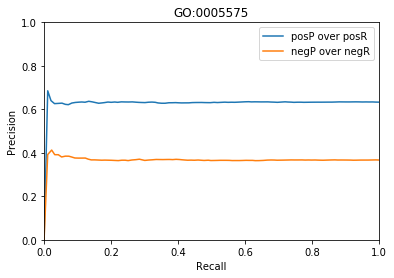

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


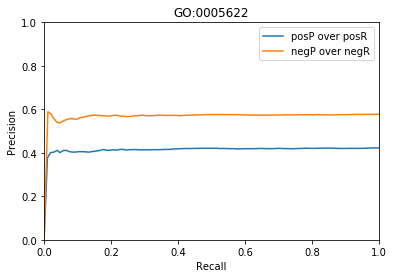

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


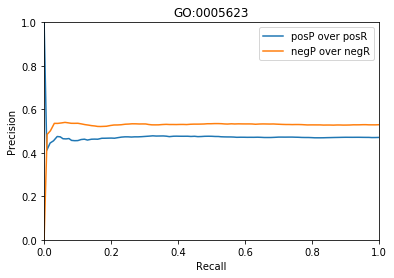

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


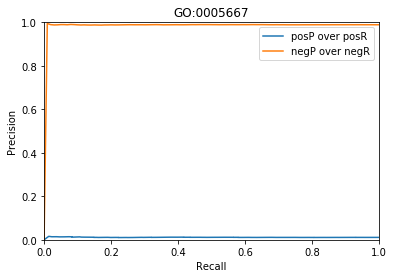

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


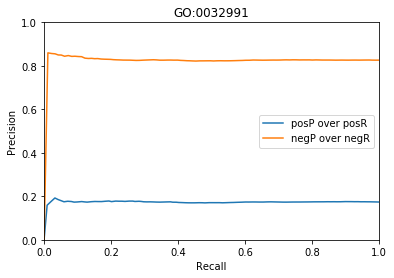

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


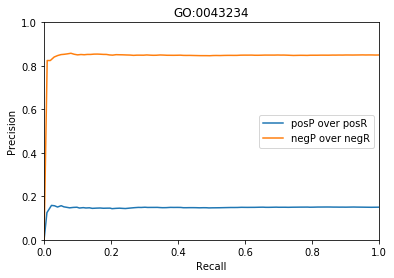

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


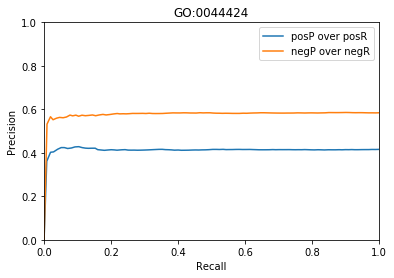

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


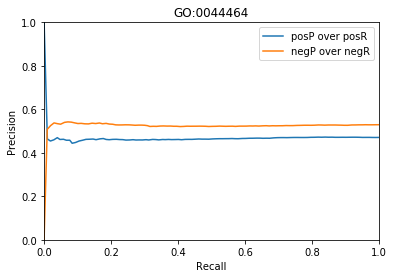

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


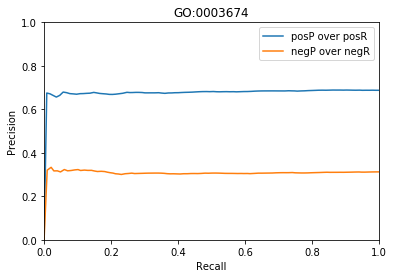

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


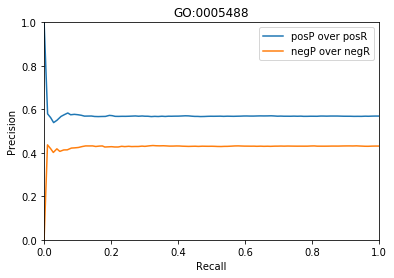

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


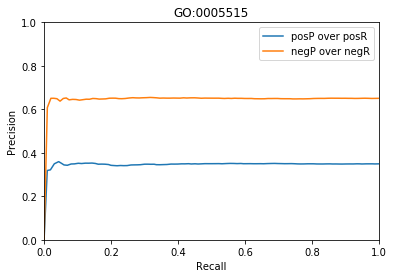

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


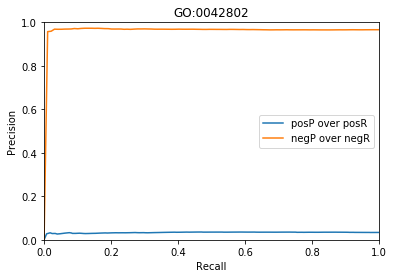

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


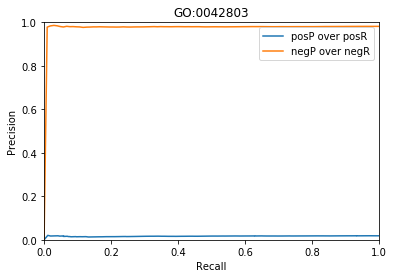

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


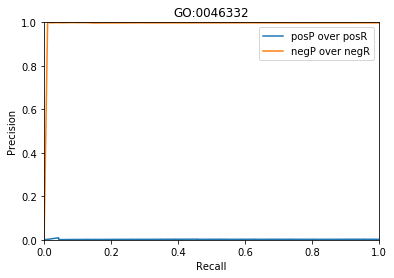

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


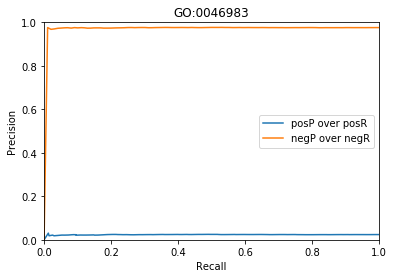

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


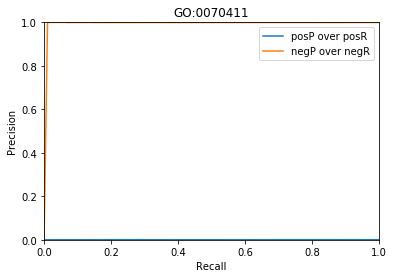

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


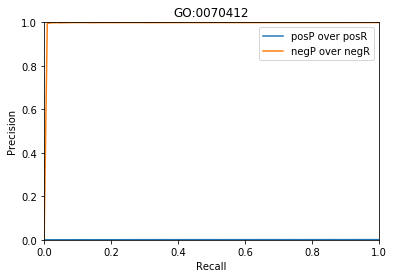

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


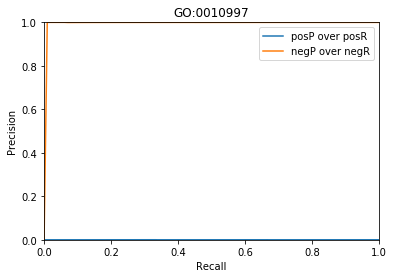

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


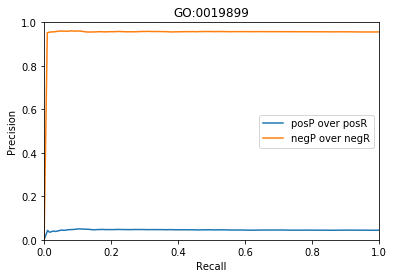

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


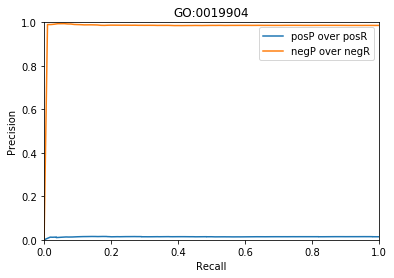

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


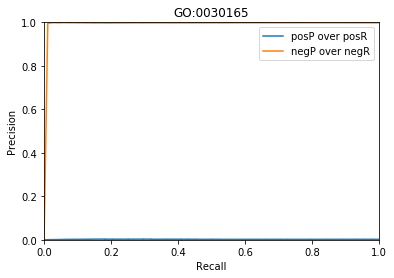

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


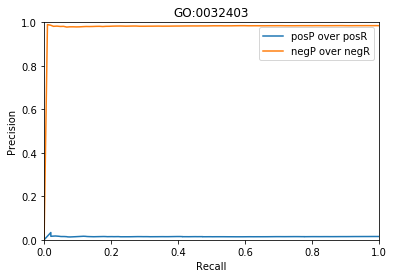

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


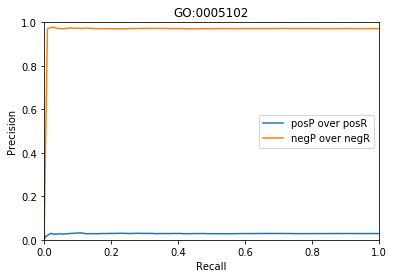

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


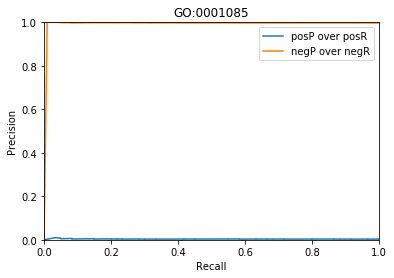

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


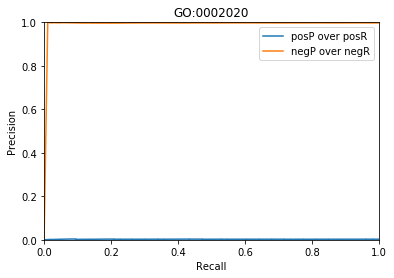

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


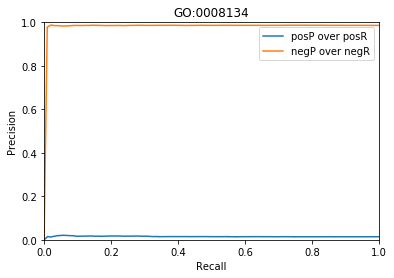

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


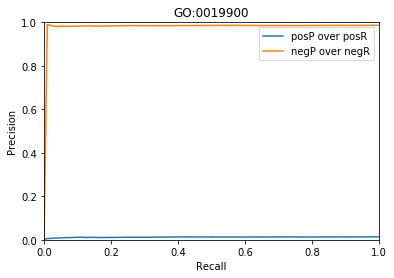

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


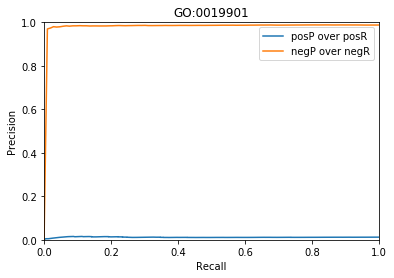

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


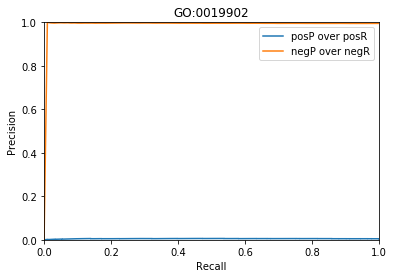

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


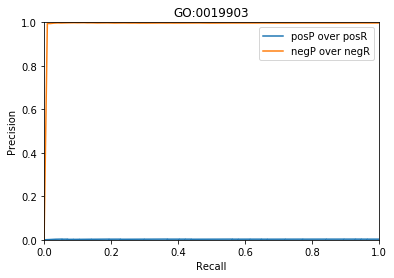

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


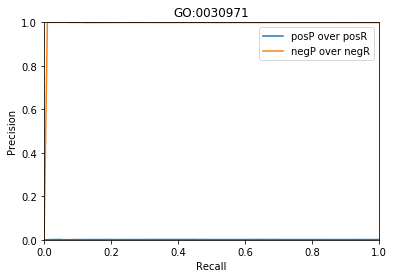

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


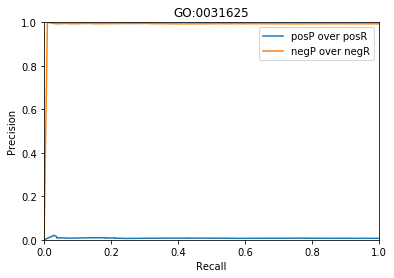

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


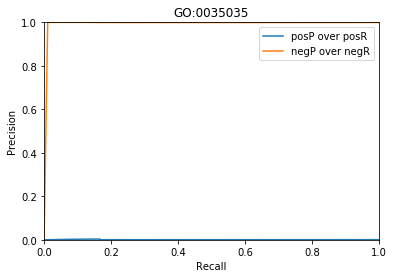

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


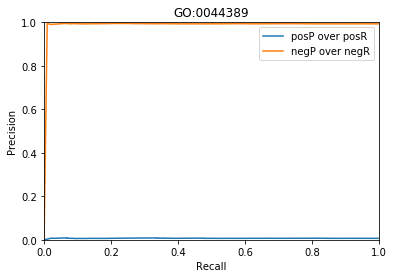

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


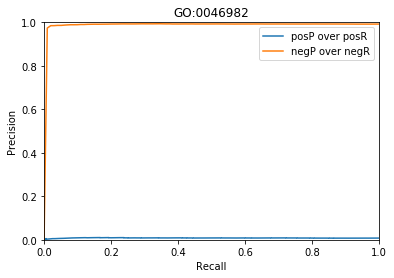

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


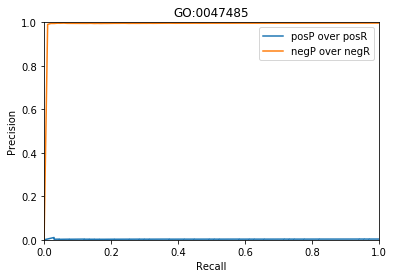

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


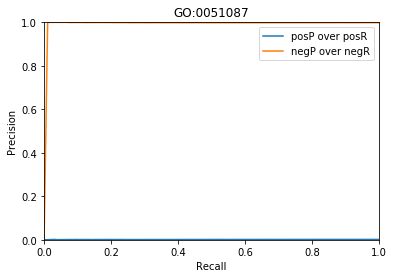

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


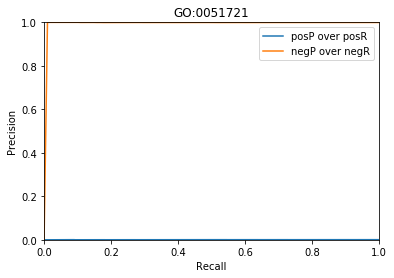

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


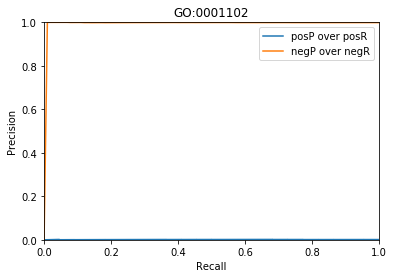

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


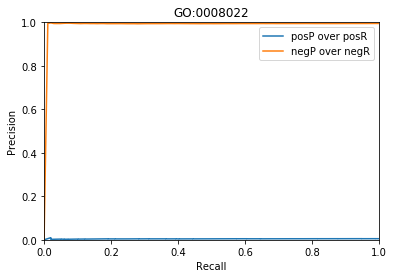

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


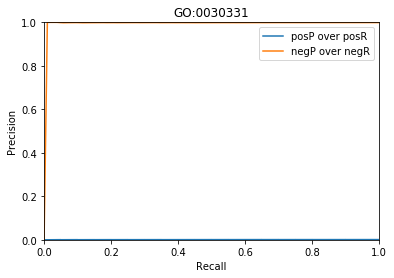

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


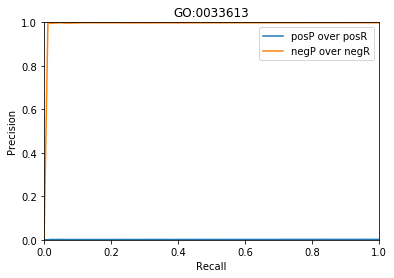

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


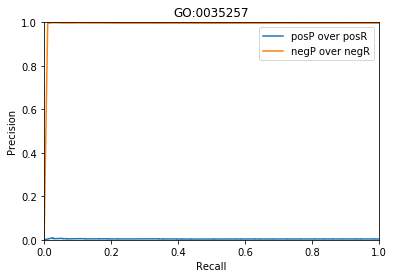

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


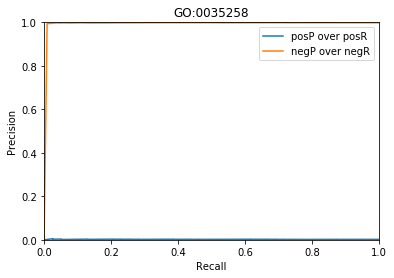

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


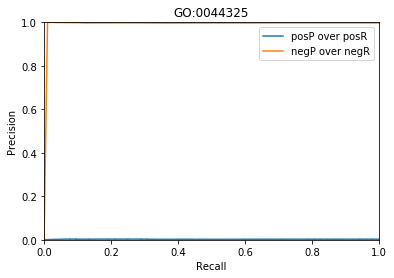

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


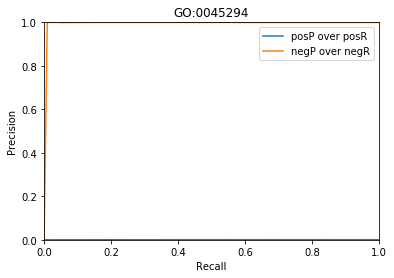

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


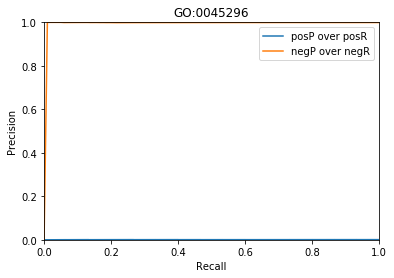

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


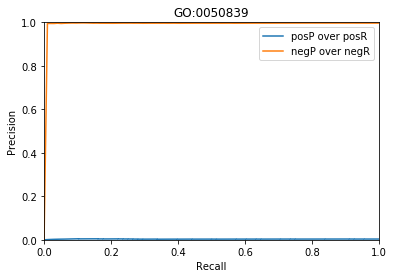

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


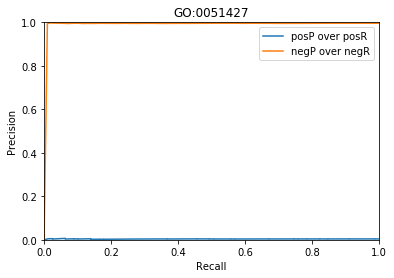

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


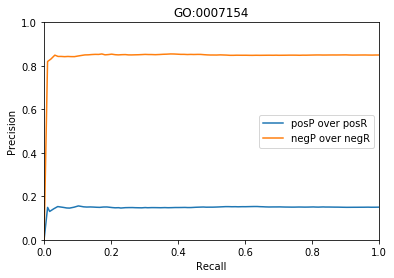

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


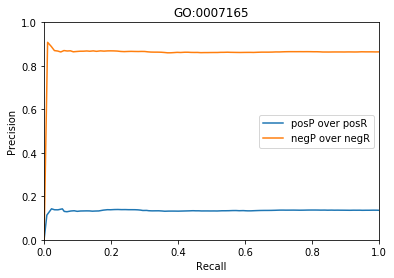

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


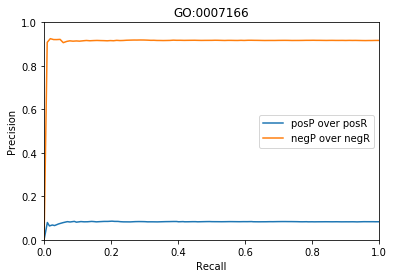

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


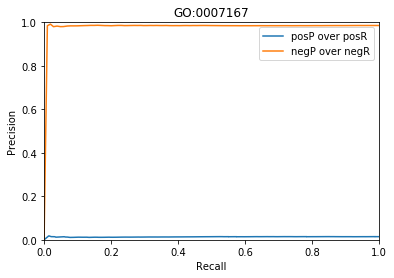

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


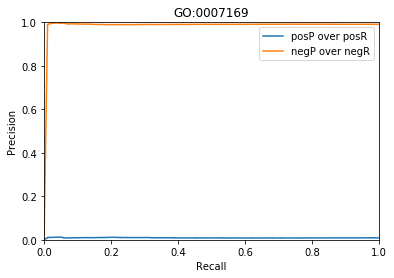

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


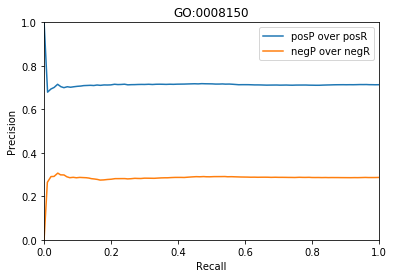

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


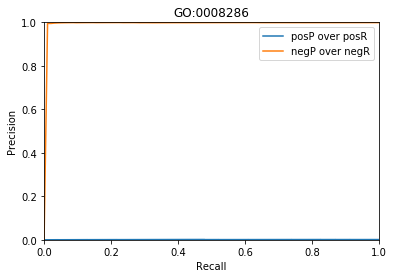

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


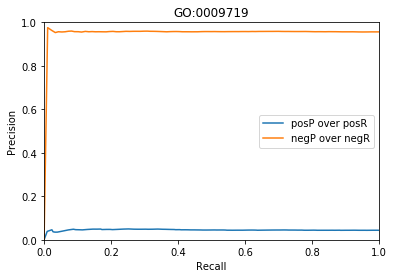

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


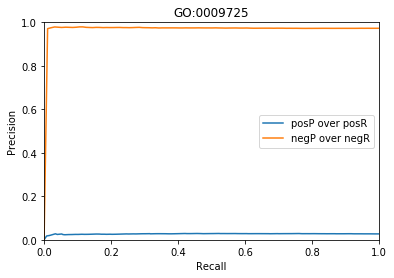

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


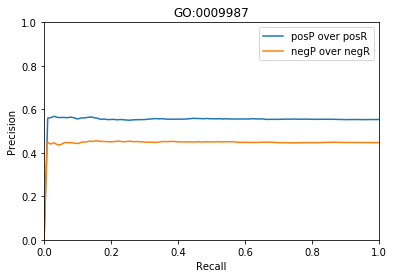

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


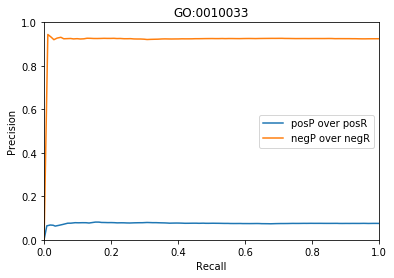

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


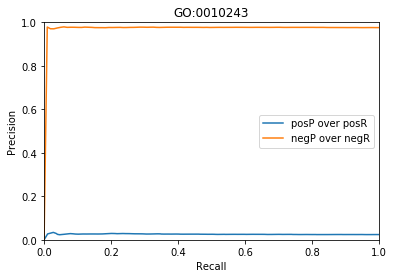

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


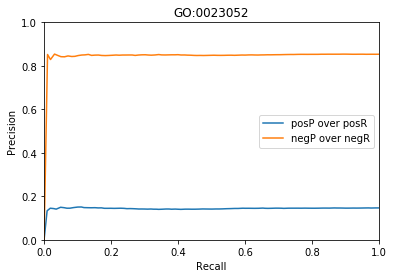

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


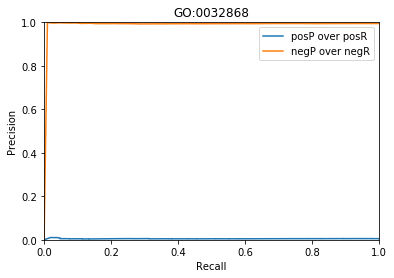

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


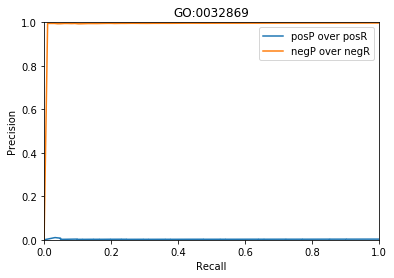

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


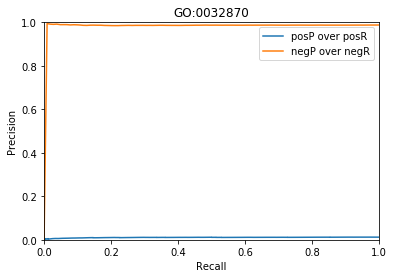

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


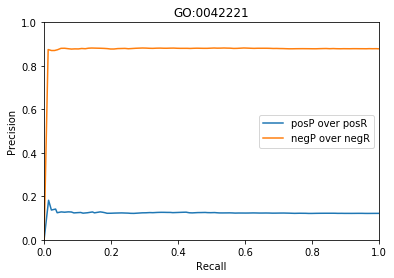

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


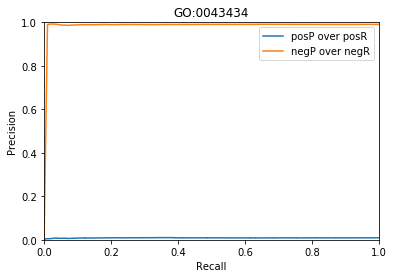

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


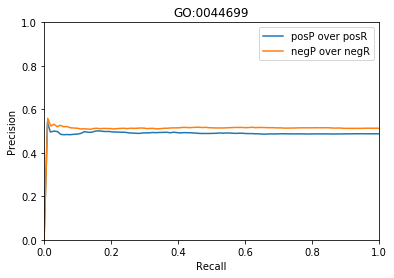

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


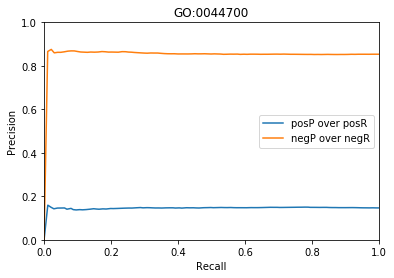

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


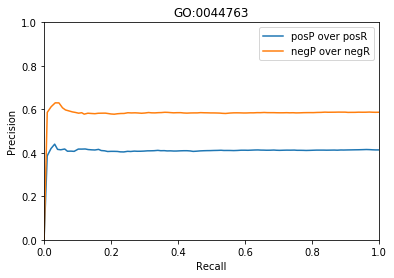

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


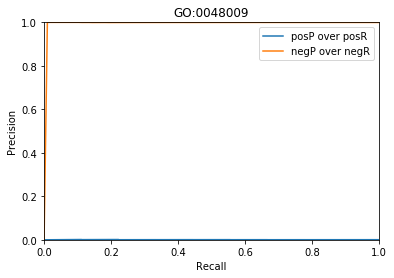

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


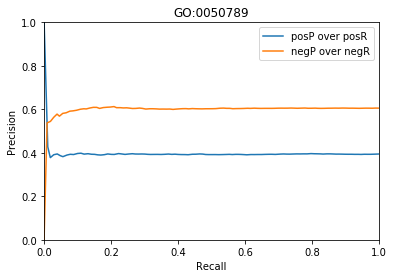

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


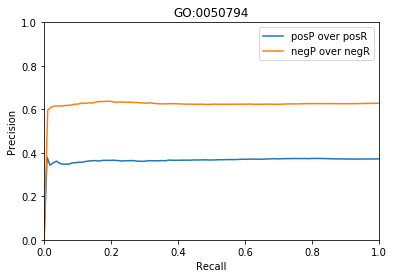

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


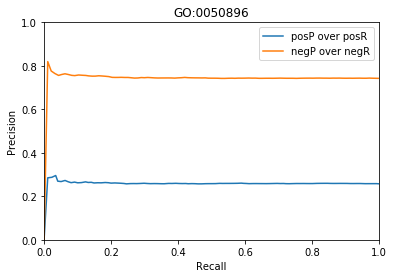

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


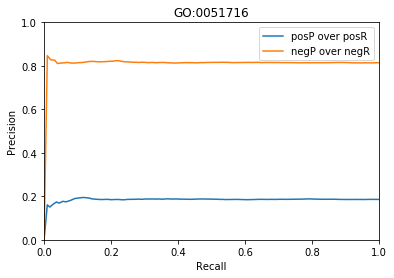

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


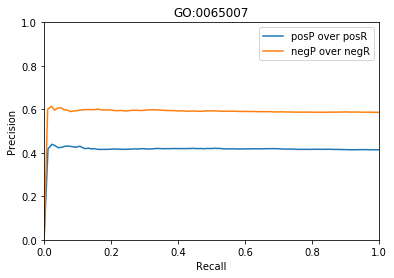

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


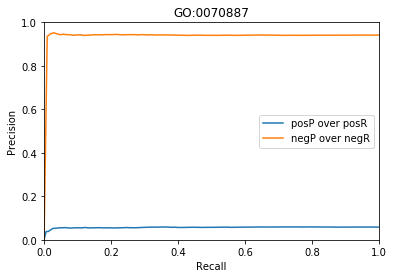

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


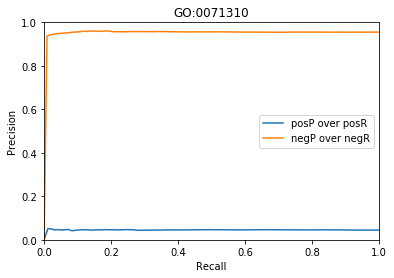

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


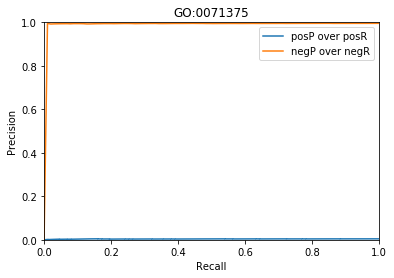

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


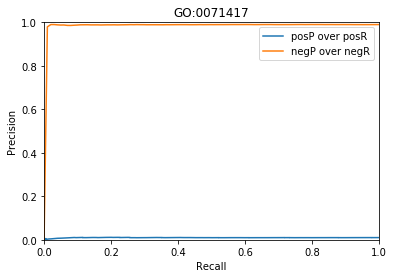

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


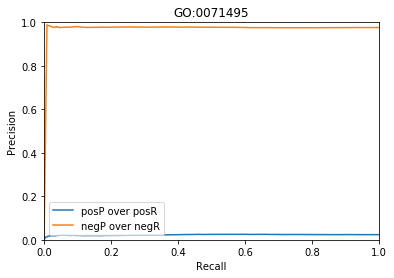

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


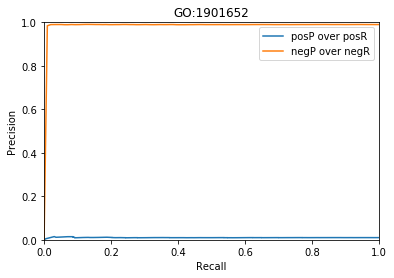

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


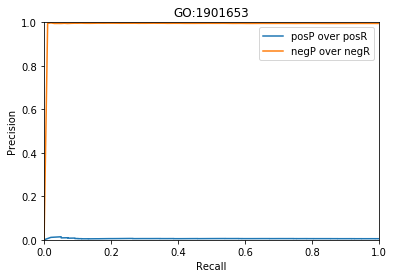

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


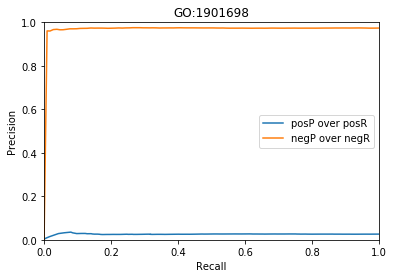

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


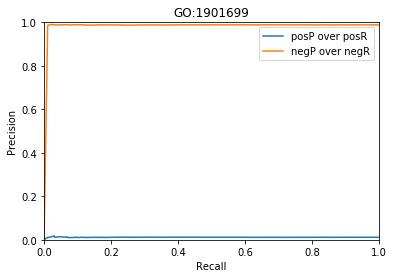

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


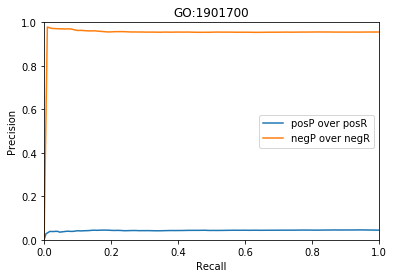

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


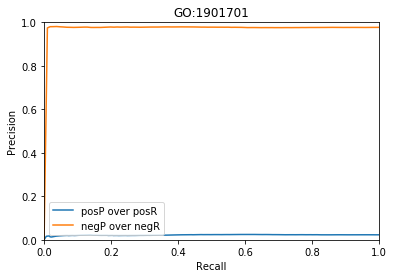

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


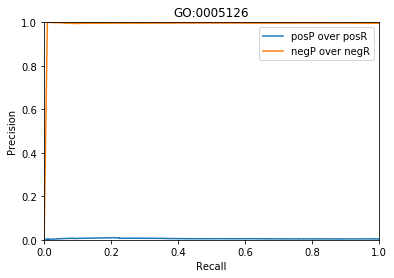

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


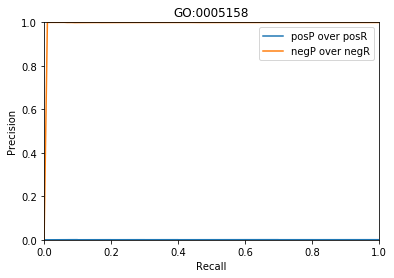

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


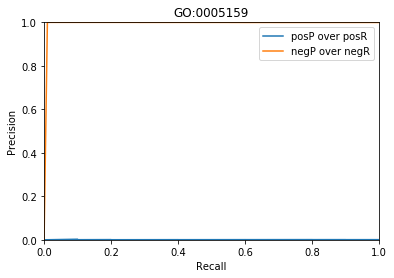

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


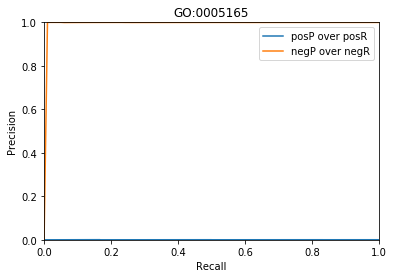

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


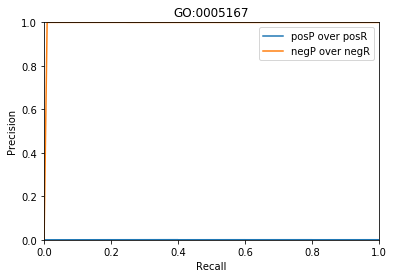

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


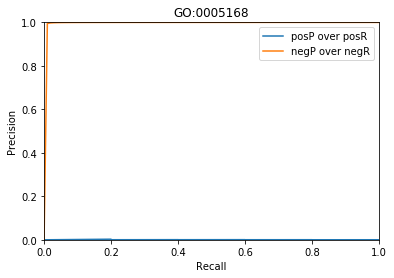

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


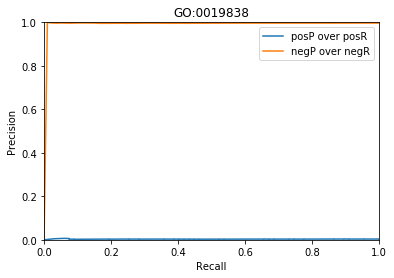

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


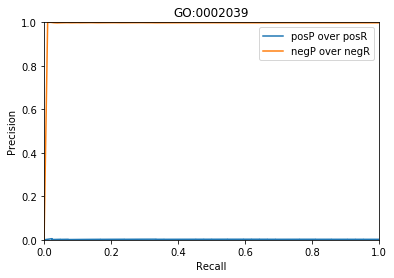

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


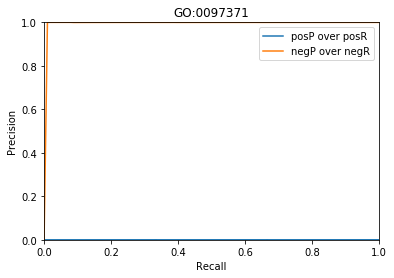

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


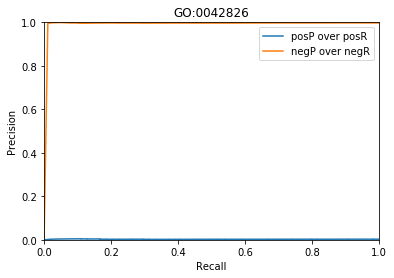

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


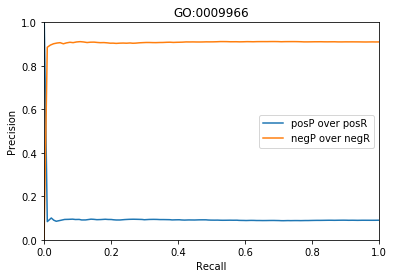

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


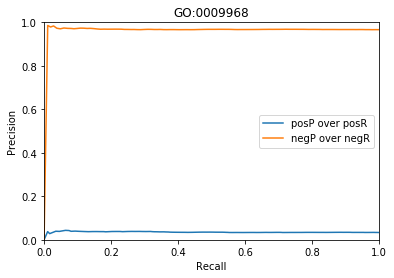

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


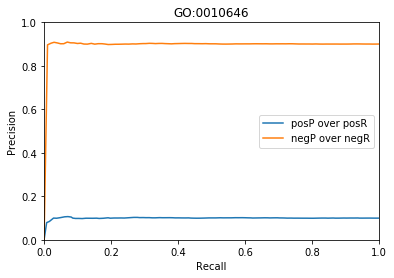

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


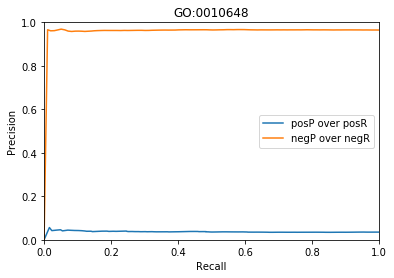

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


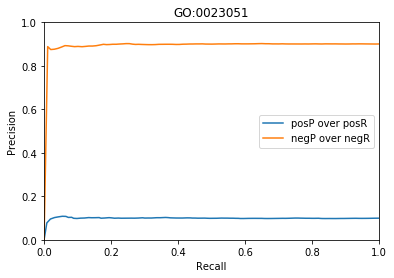

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


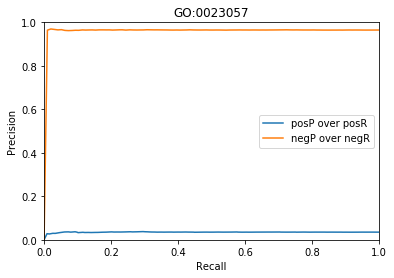

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


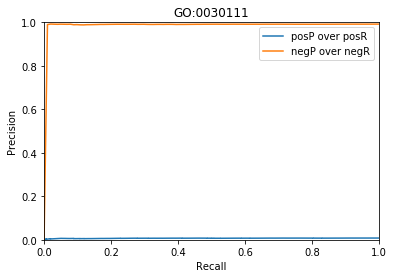

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


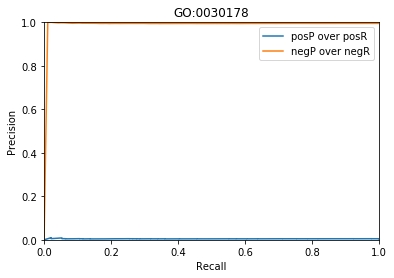

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


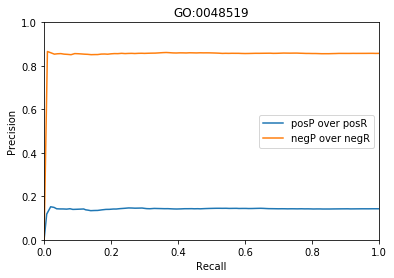

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


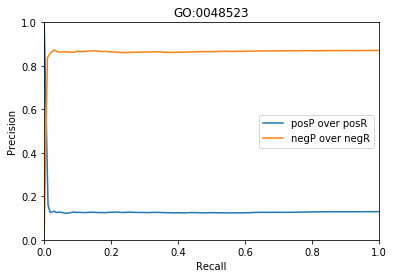

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


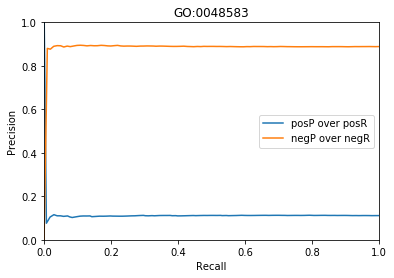

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


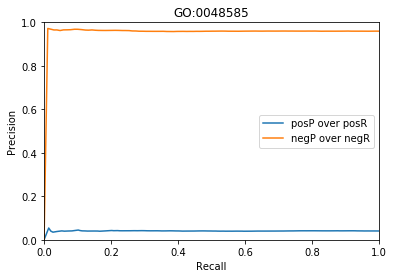

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


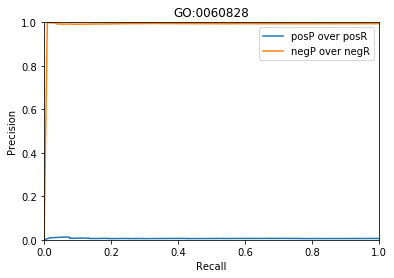

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


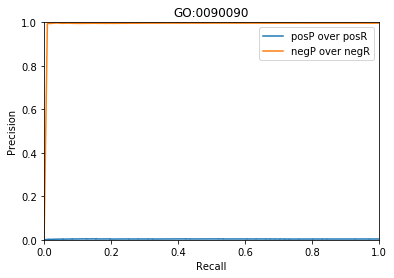

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


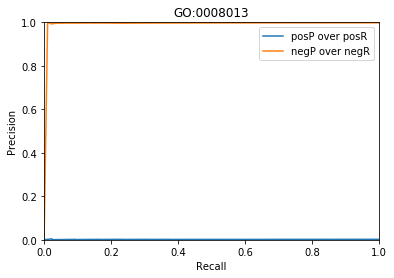

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


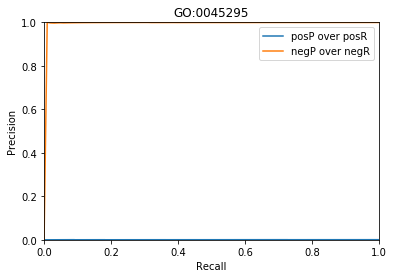

In [96]:
m.make_graphs(show=True)

In [100]:
m2 = MetricGrapher(pm, ph, Y, go)

file not saved, see line 13 in Metrics.py
thresholdmin-Metrics	 0.0
thresholdmax-Metrics	 1.01
thresholdincrement-Metrics	 0.01


In [101]:
m2.new_metric(Metric.Function('fpr'), Metric.Function('tpr'))
m2.initialize_metrics()

file not saved, see line 13 in Metrics.py


/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


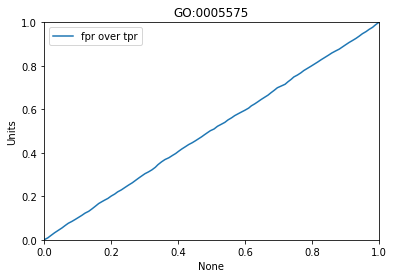

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


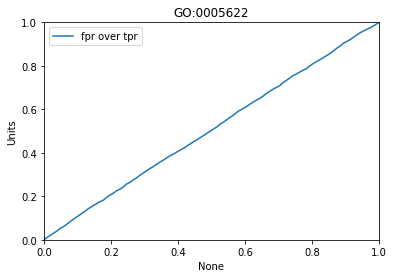

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


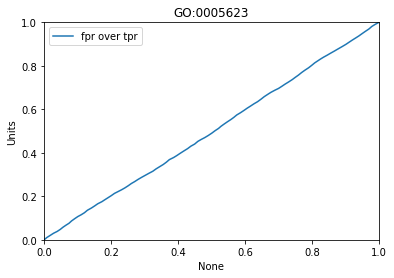

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


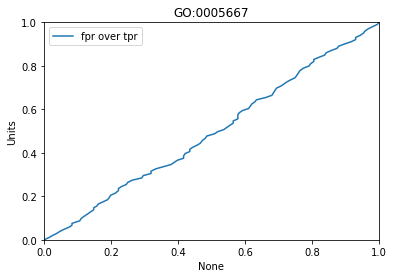

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


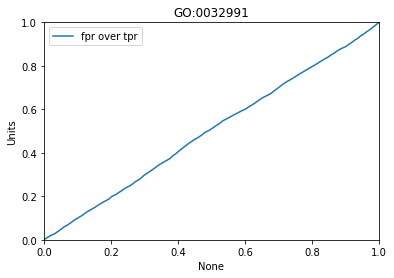

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


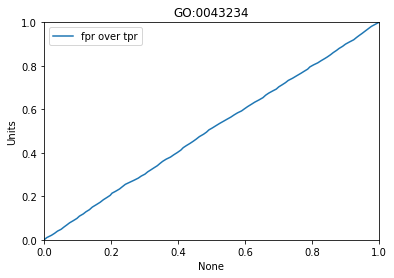

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


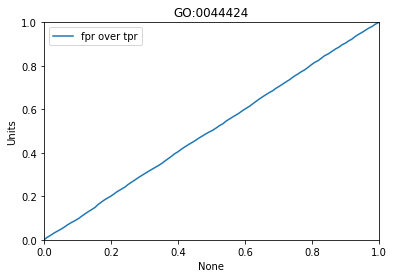

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


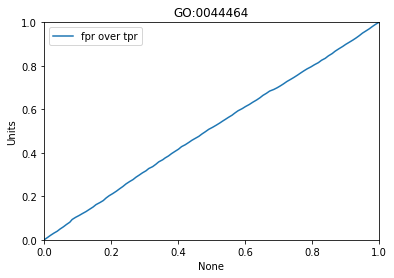

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


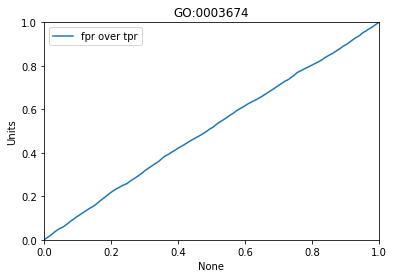

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


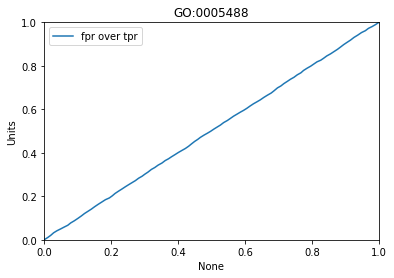

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


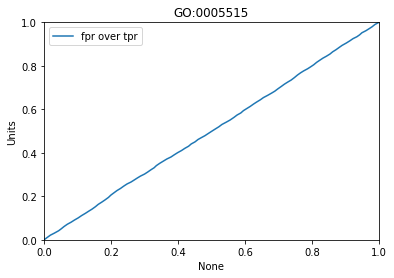

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


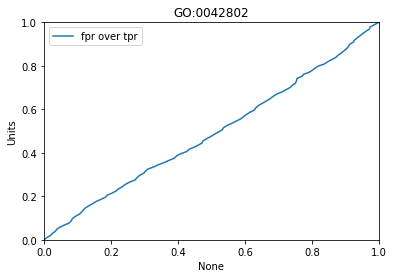

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


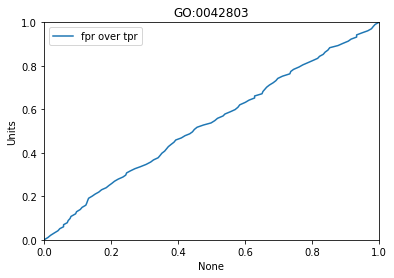

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


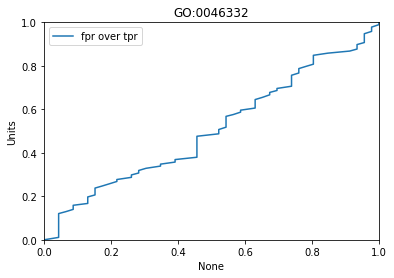

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


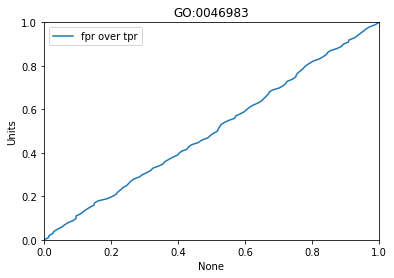

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


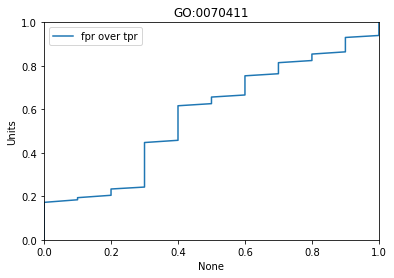

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


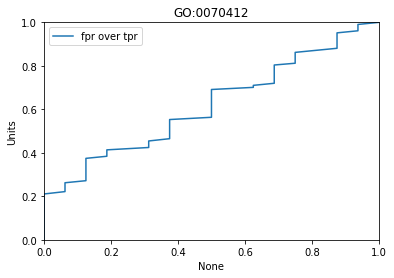

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


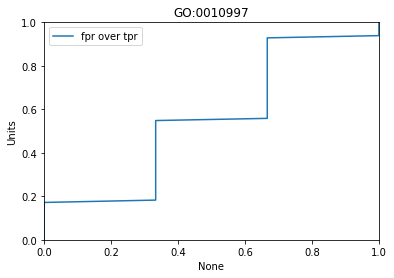

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


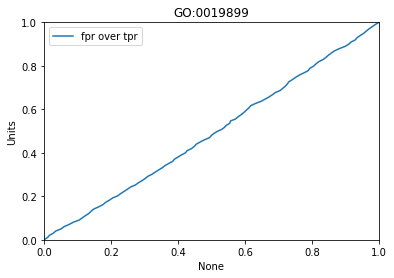

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


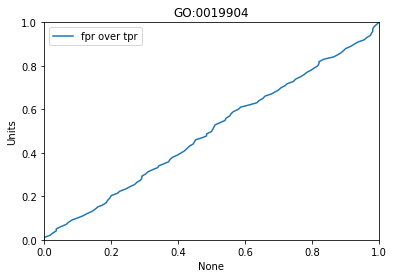

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


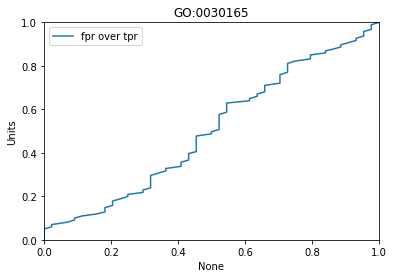

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


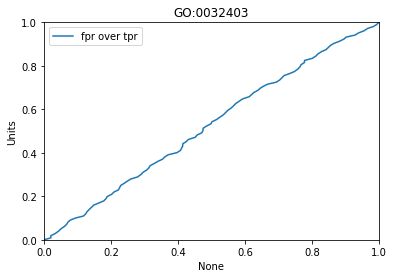

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


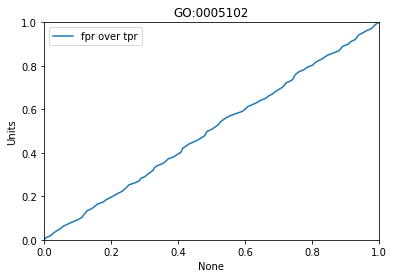

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


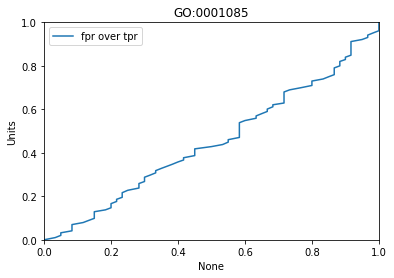

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


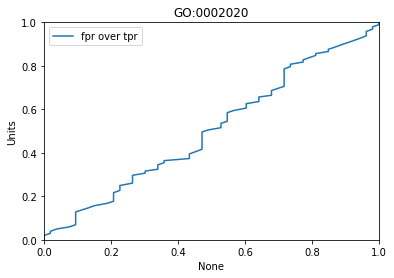

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


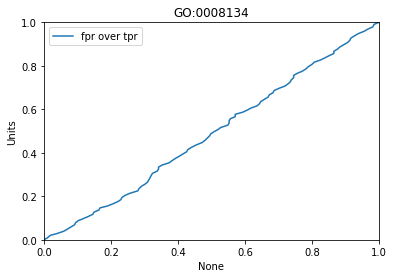

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


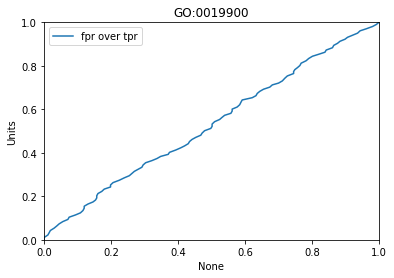

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


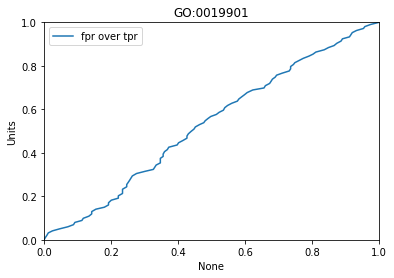

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


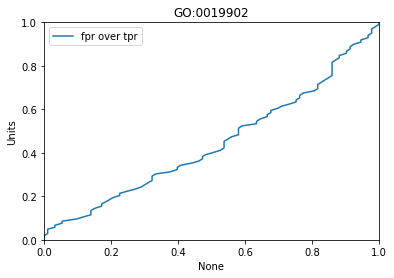

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


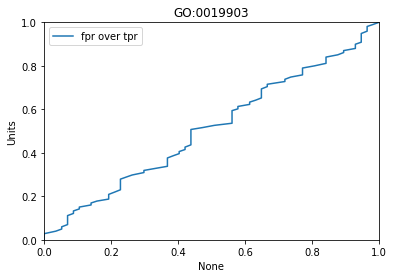

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


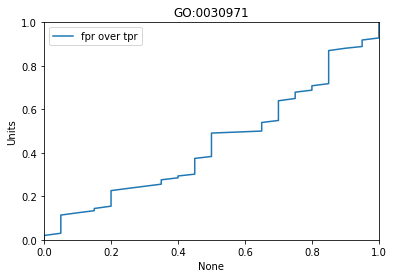

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


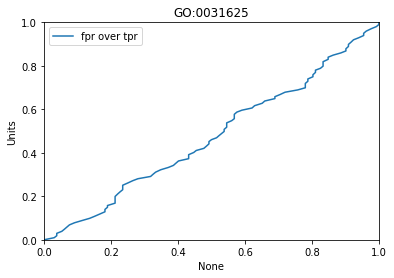

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


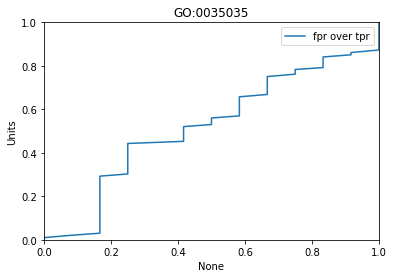

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


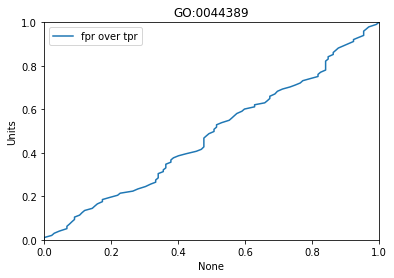

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


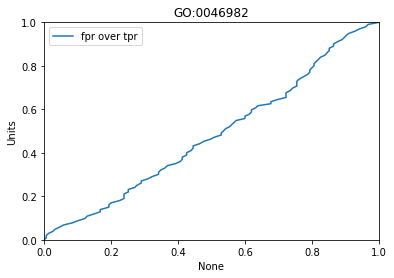

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


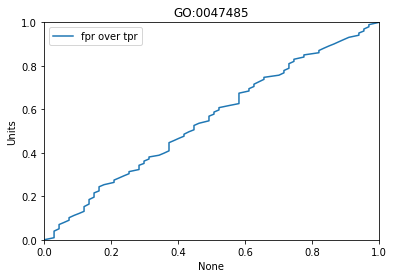

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


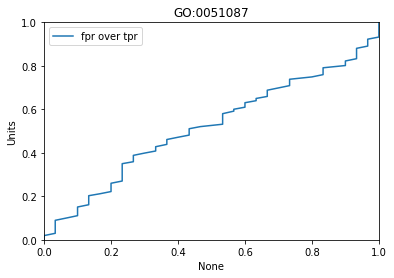

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


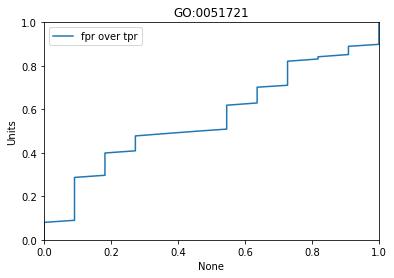

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


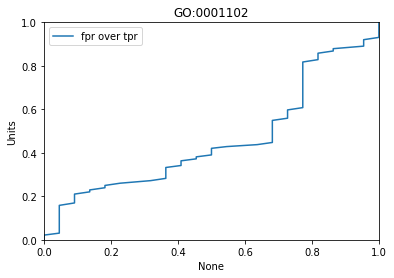

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


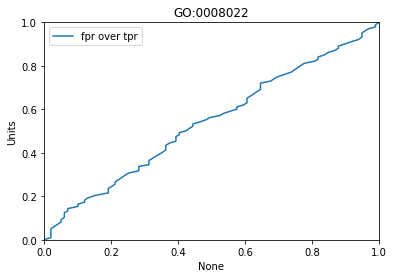

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


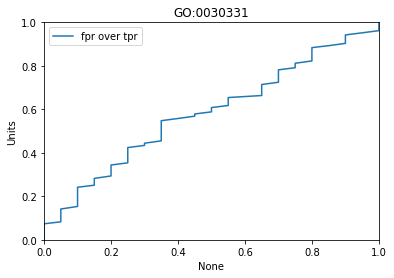

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


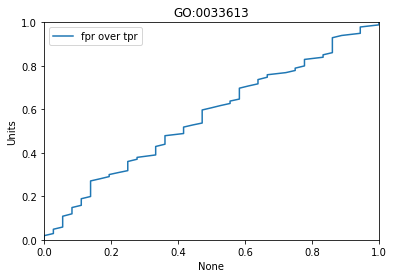

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


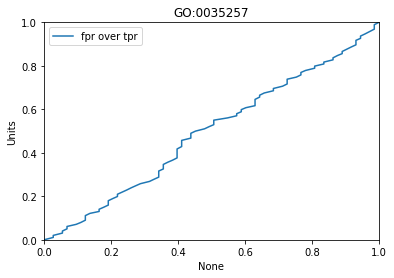

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


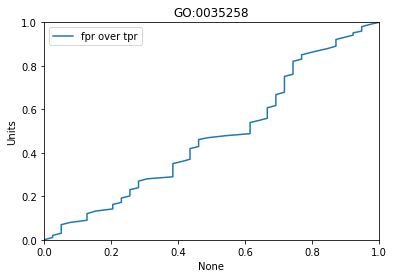

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


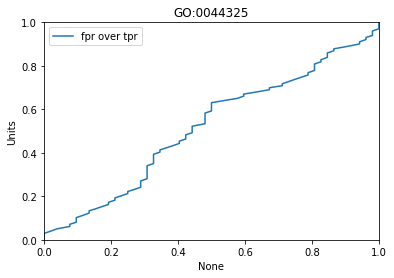

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


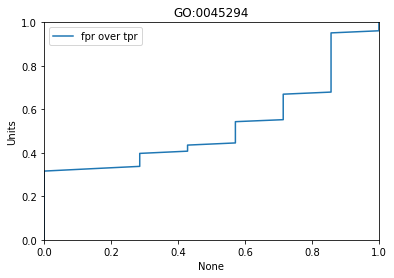

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


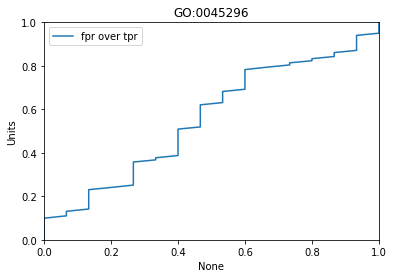

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


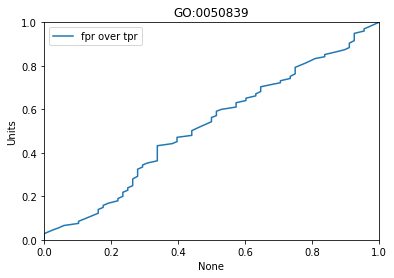

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


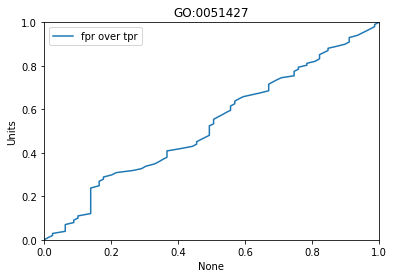

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


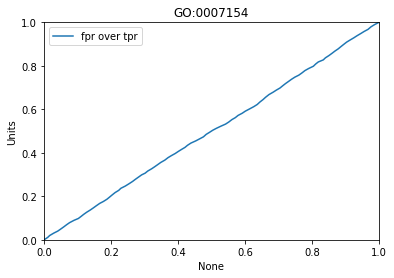

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


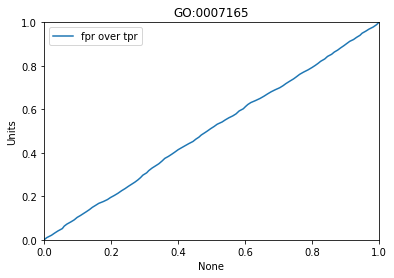

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


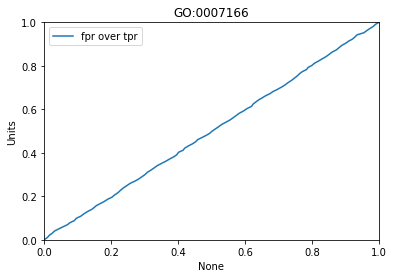

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


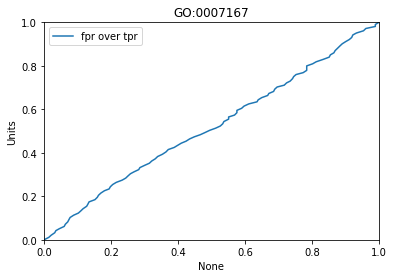

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


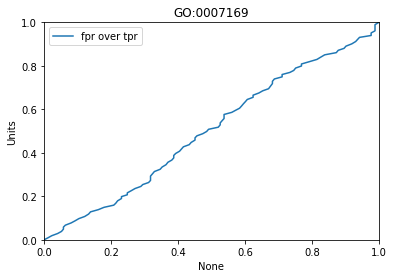

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


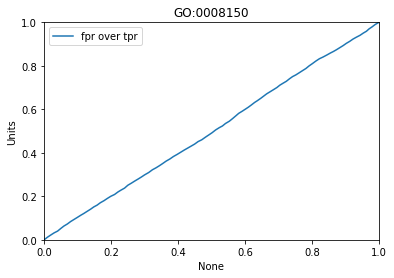

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


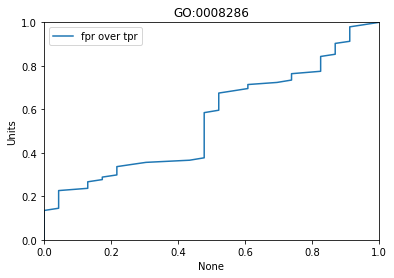

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


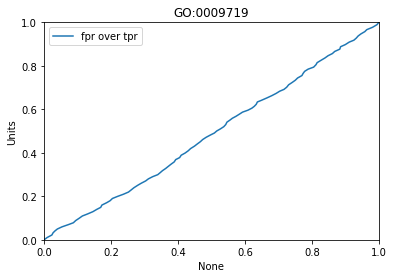

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


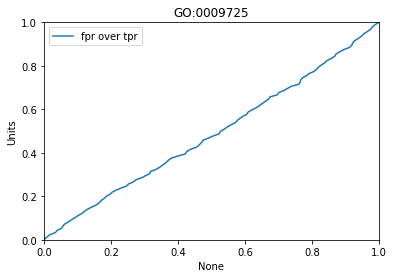

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


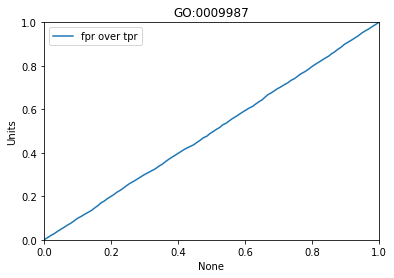

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


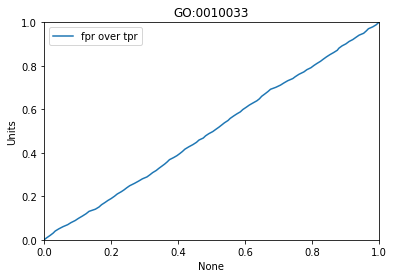

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


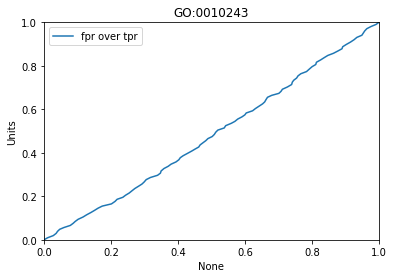

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


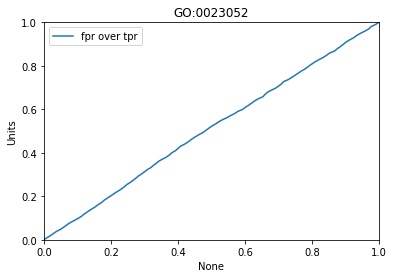

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


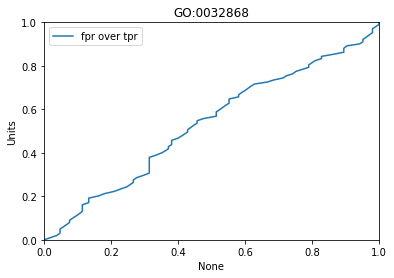

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


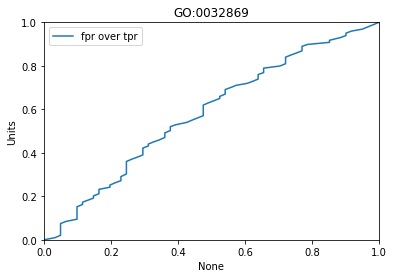

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


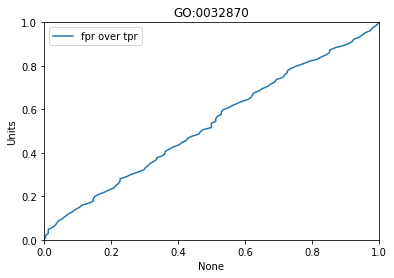

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


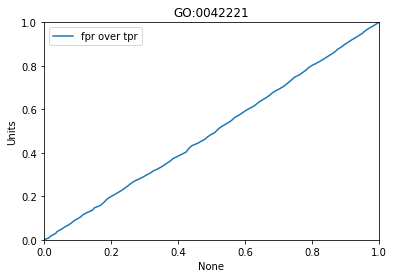

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


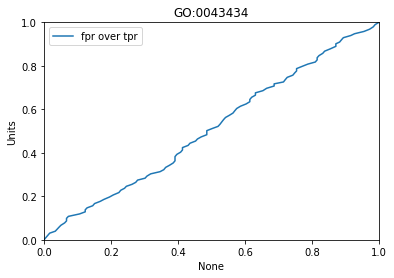

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


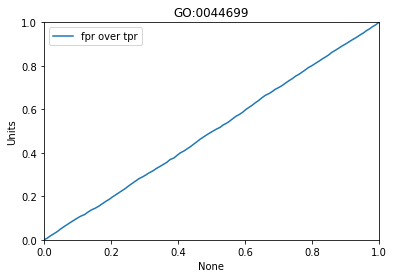

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


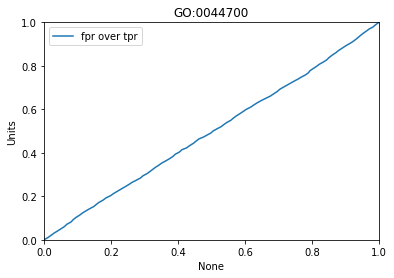

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


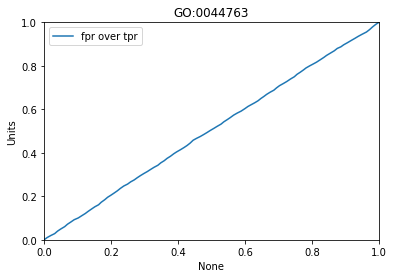

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


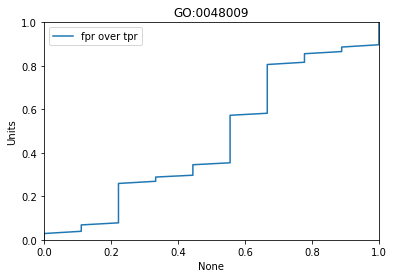

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


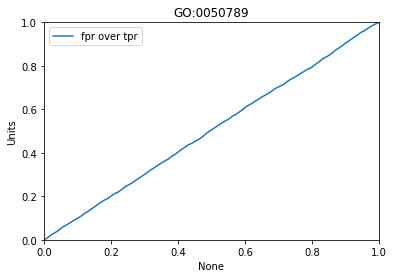

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


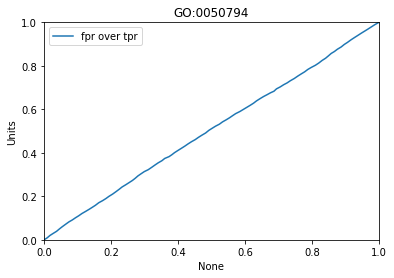

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


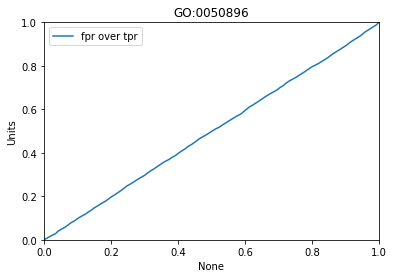

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


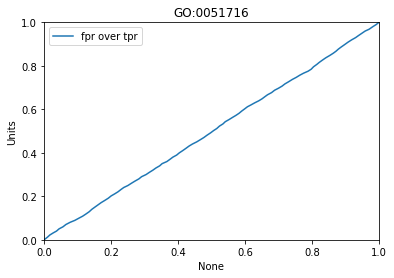

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


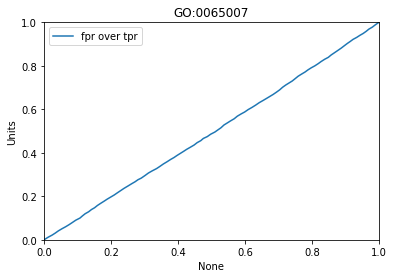

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


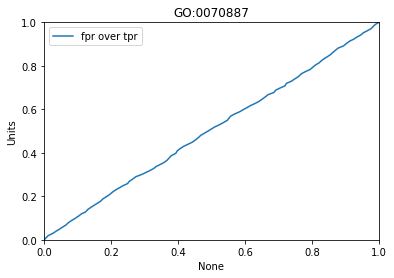

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


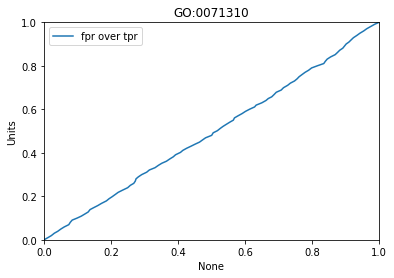

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


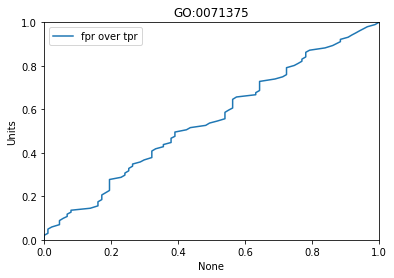

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


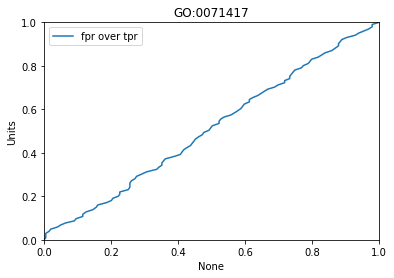

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


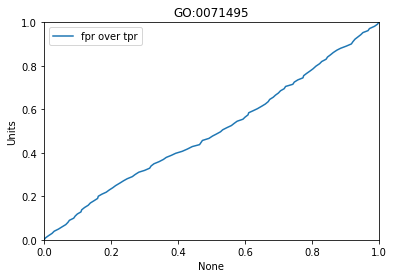

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


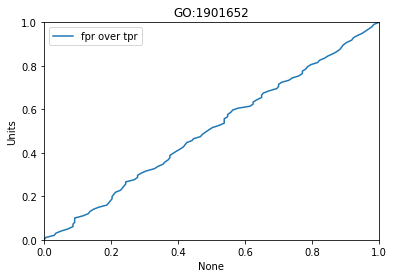

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


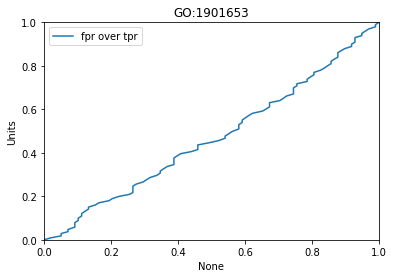

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


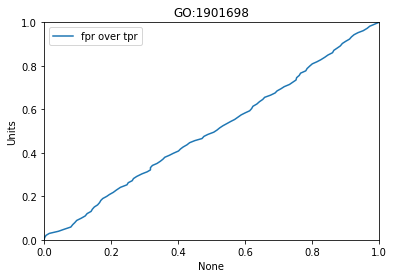

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


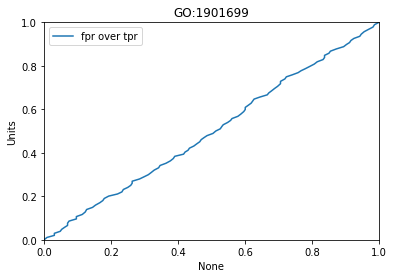

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


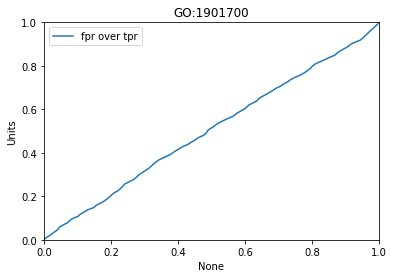

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


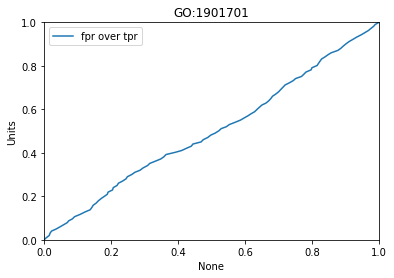

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


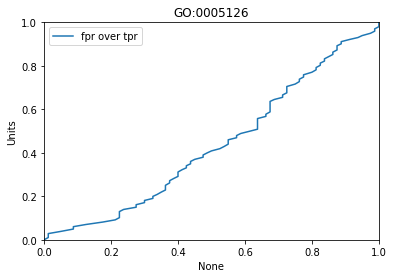

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


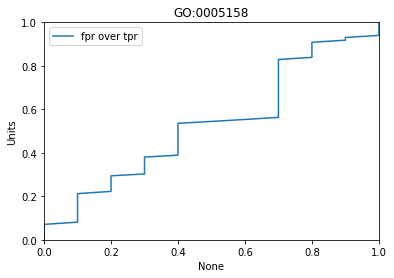

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


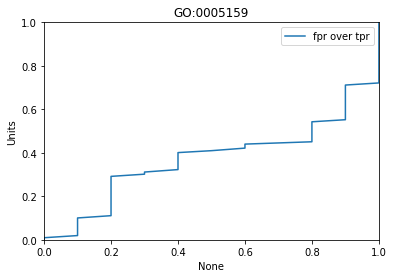

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


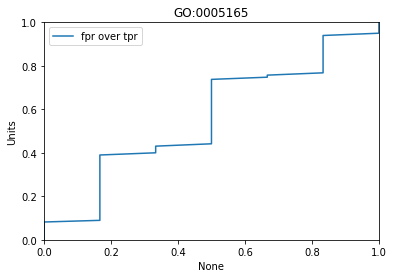

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


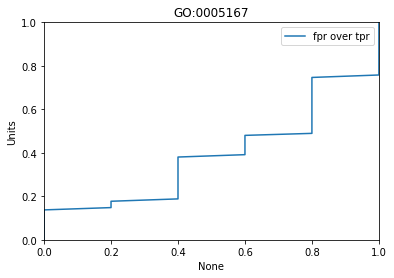

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


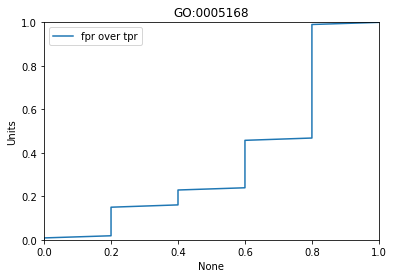

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


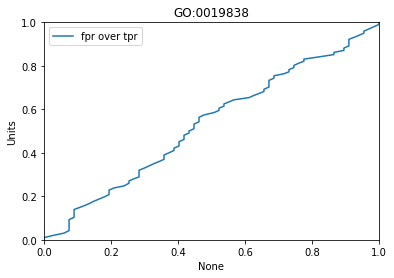

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


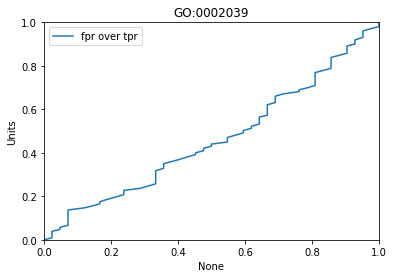

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


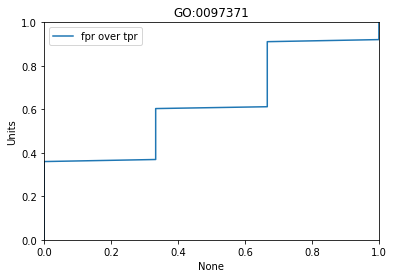

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


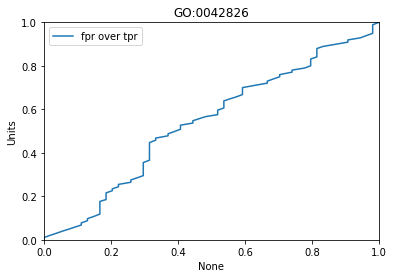

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


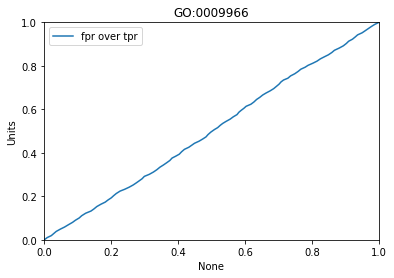

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


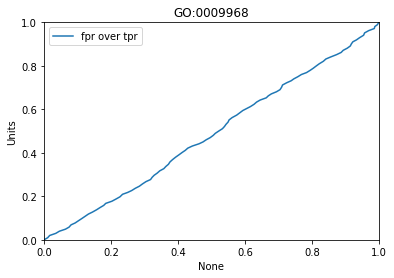

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


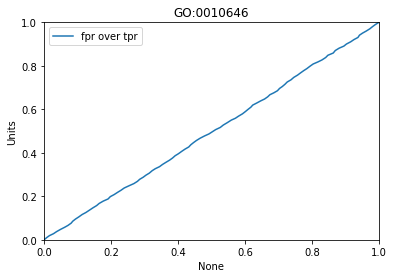

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


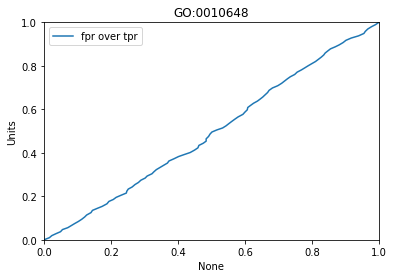

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


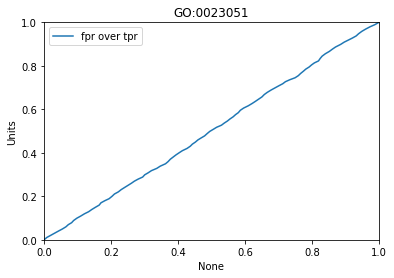

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


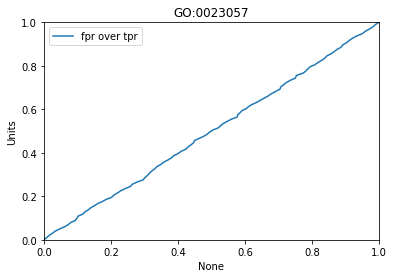

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


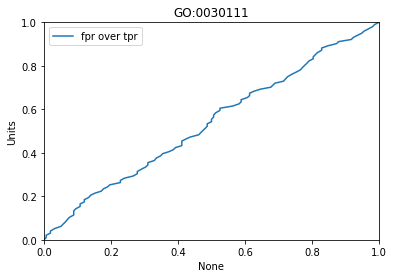

/home/shelby/.conda/envs/tensorflowgpu/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


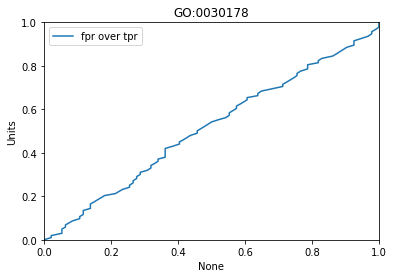

KeyboardInterrupt: 

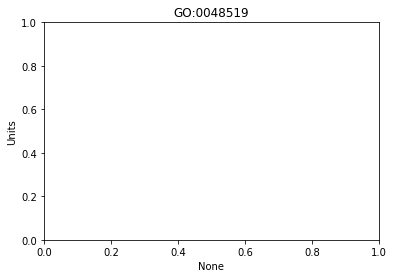

In [102]:
m2.make_graphs(show=True)